RMSE(training)0.000
RMSE(test)38691.463


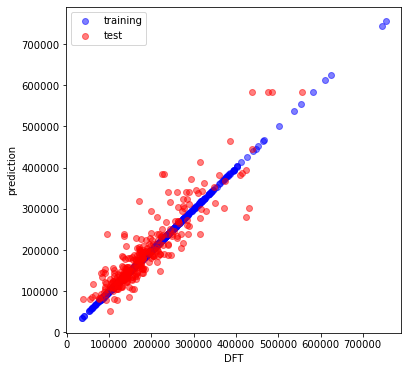

In [2]:
#导入数据
from sklearn.datasets import fetch_openml

house = fetch_openml(name = 'house_prices', as_frame = True)

#寻找所有的类别列，以区分哪些是文本数据，哪些是数值数据。以便于进行独热编码。
cat_columns = house.data.select_dtypes(include=['object', 'category']).columns.tolist()   # 文本型数据
num_columns = house.data.select_dtypes(exclude=['object', 'category']).columns.tolist()   #数值型数据

#下面对数据进行归类和处理

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline #用于创建一个处理流程，它串联多个转换步骤和一个估计器（如模型）

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(house.data, house.target, test_size = 0.2, random_state = 2) 

X_train_cat = X_train[cat_columns]
X_train_num = X_train[num_columns]
X_test_cat = X_test[cat_columns]
X_test_num = X_test[num_columns]


#下面对不同类型的数据处理一下
from sklearn.preprocessing import StandardScaler

scaler_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore')) 
#OneHotEncoder(handle_unknown='ignore')这一步是为了处理测试集中有与训练集中不存在的类别时，独热编码器报错。
#更好的处理方式可能是这样：在开始模型训练之前，检查数据集中的所有可能类别，并确保训练集和测试集中的类别一致。这可能涉及到数据清洗或预处理步骤，比如将稀有类别合并为一个共同类别。

X_train_cat_enc = scaler_cat.fit_transform(X_train_cat)
X_test_cat_enc = scaler_cat.transform(X_test_cat)

scaler_num = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

#输出转换后的稀疏矩阵
#print(X_train_cat_enc)
#print(X_train_num_scaled)

#当您尝试打印 X_train_cat_enc 时，如果它是稀疏矩阵格式，将不会直接显示所有数据。相反，
#它通常会显示矩阵的非零位置和值的压缩表示，或者简单地显示矩阵的存储格式和尺寸信息。

#打印 X_train_num_scaled 时，通常会显示一个完整的密集数组，其中每个元素都有具体
#的值（填充和转换后的数值），这与独热编码生成的稀疏格式截然不同。


#下面对处理后的文本数据与数字数据合并
import numpy as np
from scipy import sparse

X_train = sparse.hstack((X_train_cat_enc,
                                sparse.csr_matrix(X_train_num_scaled))) # 文本数据和数字数据进行合并
X_test = sparse.hstack((X_test_cat_enc,
                               sparse.csr_matrix(X_test_num_scaled)))   # 文本数据和数字数据进行合并

#进行线性回归

from sklearn import tree

clf = tree.DecisionTreeRegressor()  #进行决策树回归
clf = clf.fit(X_train, y_train)   #进行拟合

y_pred_train_clf = clf.predict(X_train)
y_pred_test_clf= clf.predict(X_test)

#作图
import matplotlib.pyplot as plt

plt.figure(figsize = (6, 6))
plt.scatter(y_train, y_pred_train_clf, alpha = 0.5, color = 'b', label = 'training')  #alpha设置透明度
plt.scatter(y_test, y_pred_test_clf, alpha = 0.5, color = 'r', label = 'test')
plt.legend()
plt.xlabel('DFT')
plt.ylabel('prediction')

#算均方误差
from sklearn.metrics import mean_squared_error #引用均方差
rmse_tr_clf = mean_squared_error(y_train, y_pred_train_clf, squared = False) #squared = False 是表示对均方差求根，及得到均方根误差
rmse_te_clf = mean_squared_error(y_test, y_pred_test_clf, squared = False)
print('RMSE(training)%.3f'%rmse_tr_clf)
print('RMSE(test)%.3f'%rmse_te_clf)

In [9]:
#交叉验证

from sklearn.model_selection import cross_val_score, KFold

# 再次合并为完整的X
X = sparse.vstack((X_train, X_test))
y = np.concatenate([y_train, y_test])  #必须确保X与y的数据一一对应。

crossvalidation = KFold(n_splits = 5, shuffle = True)  #打乱分割方法
r2_scores_clf = cross_val_score(clf, X, y, scoring = 'r2', cv = crossvalidation)  #scoring = 'r2' 决定系数的打分方法
rmse_scores_clf = cross_val_score(clf, X, y, scoring = 'neg_root_mean_squared_error', cv = crossvalidation) #scoring = 'neg_root_mean_squared_error' RMSE打分方法

print('cv result:')
print('Fold: %i, mean R2: %.3f' %(len(r2_scores_clf), r2_scores_clf.mean()))  #cv=5，所以每次验证都会得到r2,最后得到一个数组。所以后面还有一个求平均
print('Fold: %i, mean RMSE: %.3f' %(len(rmse_scores_clf), -rmse_scores_clf.mean()))

cv result:
Fold: 5, mean R2: 0.701
Fold: 5, mean RMSE: 42567.094


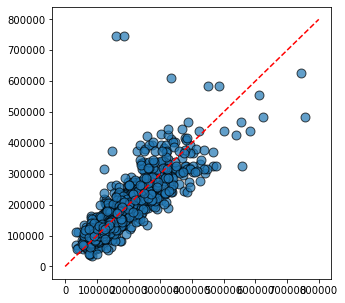

In [10]:
from sklearn.model_selection import cross_val_predict
y_new = cross_val_predict(clf, X, y, cv = crossvalidation) #将进行k折交叉验证的结果更新
plt.figure(figsize = (5, 5))
plt.plot([0, 800000], [0, 800000], 'r--')
plt.scatter(y, y_new, s = 80, edgecolor = 'k', alpha = 0.7)